In [1]:
import warnings
warnings.filterwarnings('ignore')

from functools import partial
import pyproj
from shapely.geometry import Point
from shapely.ops import transform
import pandas as pd
import geopandas as gpd
import numpy as np
from tqdm.auto import tqdm
# import joblib
from joblib import Parallel, delayed
import itertools

In [2]:
def spatial_points(df, lat, lon, to_mercator = False):
    geometry = [Point(xy) for xy in zip(df[lon], df[lat])]
    if to_mercator:
        gdf = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'}, geometry=geometry)
        gdf = gdf.to_crs(epsg=3857)
        
    else:
        gdf = gpd.GeoDataFrame(df, crs={'init': 'epsg:4326'}, geometry=geometry)
        
    return gdf

def geodesic_point_buffer(lon, lat, km):
    # Azimuthal equidistant projection
    proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84')
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lon=lon, lat=lat)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return transform(project, buf)

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

df = pd.concat([train, test])
df = df[['id', 'lat', 'lng', 'price_type', 'realty_type', 'per_square_meter_price']]

In [4]:
def geodesic_buffer(df):
    geom = df.apply(lambda row: geodesic_point_buffer(row['lng'], row['lat'], radius / 1000), axis=1)
    buffers = df.copy()
    buffers = gpd.GeoDataFrame(buffers, geometry=geom, crs={'init': 'epsg:4326'})
    buffers = buffers[['id', 'geometry']]
    return buffers

In [5]:
def get_batches(df, batch_size=1000):
    batch_nums = int(np.ceil(df.shape[0]/batch_size))
    batches = [df[batch_size*i:batch_size*i+batch_size] for i in range(batch_nums)]
    return batches

In [6]:
def spatial_join(data):
    df_a = data[0]
    df_b = data[1]
    return gpd.sjoin(df_a, df_b)

In [7]:
%%time
out = df[['id']]
for radius in tqdm([100, 250, 500, 1000, 5000]):
    all_types = []
    for realty_type in df['realty_type'].unique():

        df_realty_type = df[df['realty_type'] == realty_type]

#         geom = df_realty_type.apply(lambda row: geodesic_buffer(row['lng'], row['lat'], radius / 1000), axis=1)
#         buffers = df_realty_type.copy()
#         buffers = gpd.GeoDataFrame(buffers, geometry=geom, crs={'init': 'epsg:4326'})
        
        buffers = Parallel(n_jobs=-1)(delayed(geodesic_buffer)(i) for i in get_batches(df_realty_type))
        buffers = pd.concat(buffers)
#         buffers.to_file('buffers_{}.geojson'.format(radius), driver='GeoJSON')

        points = df_realty_type.copy()
        points = points[points['price_type'] == 0]
        points = spatial_points(points, lat='lat', lon='lng')
        points = points.drop(['price_type', 'realty_type', 'lat', 'lng'], axis=1)

        stat = Parallel(n_jobs=-1)(delayed(spatial_join)(i) 
                                   for i in itertools.product(get_batches(points, batch_size=30000), 
                                                              get_batches(buffers, batch_size=30000)
                                                             )
                                  )
        stat = pd.concat(stat)
        stat = stat[stat['id_left'] != stat['id_right']]
        stat = stat[['id_right', 'per_square_meter_price']]
        stat.columns = ['id', 'price']
        stat = stat.groupby('id').agg([np.mean, np.std, np.median, np.min, np.max])
        stat = stat.reset_index()
        stat.columns = ['_'.join(i) + '_r_{}'.format(radius) if 'id' not in i else 'id' for i in stat.columns ]
        
        all_types.append(stat)
    all_types = pd.concat(all_types)
    out = out.merge(all_types, on='id', how='left')

out.to_csv('prices1.csv', index=False)

/home/vervan/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/vervan/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/vervan/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be min


CPU times: user 5min 13s, sys: 43.9 s, total: 5min 57s
Wall time: 34min 47s


In [15]:
import seaborn as sns

In [13]:
out_df = df.merge(out, on='id', how='left')
cols = ['per_square_meter_price', 'price_mean_r_100', 'price_mean_r_250', 'price_mean_r_500', 'price_mean_r_1000', 'price_mean_r_5000', 'price_type']

<AxesSubplot:>

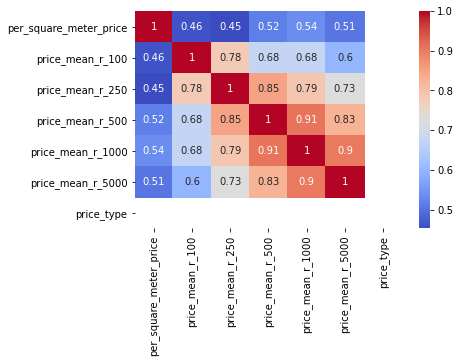

In [19]:
sns.heatmap(out_df[out_df.price_type==1][cols].corr(), annot=True, cmap='coolwarm')

<AxesSubplot:>

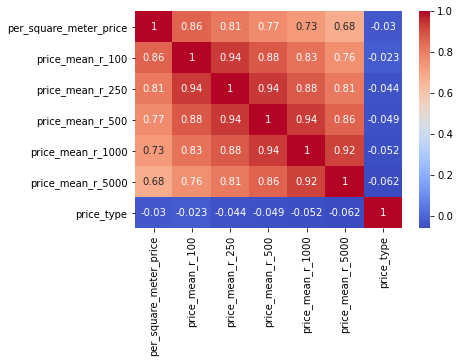

In [20]:
sns.heatmap(out_df[cols].corr(), annot=True, cmap='coolwarm')

In [ ]:
# результат выполнения этого ноутбука по ссылке https://disk.yandex.ru/d/2ZQKh85dr3D__A
# локально файл находится в папке data